# Lab 2 Sample Code

In [12]:
import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [13]:
def sigmoid(x):
    """ Sigmoid function.
    This function accepts any shape of np.ndarray object as input and perform sigmoid operation.
    """
    return 1 / (1 + np.exp(-x))


def der_sigmoid(y):
    """ First derivative of Sigmoid function.
    The input to this function should be the value that output from sigmoid function.
    """
    return y * (1 - y)

# 用relu作為前兩層的activation function
def relu(x):
    return np.maximum(0, x)

# y=0時不可微分，所以直接用左半邊的微分(等於0)
def der_relu(y):
    return (y > 0) * 1

# 避免數值過大或過小導致sigmoid輸出結果時梯度變成0
def normalize(x):
    return (x-np.mean(x, axis=1, keepdims=True))/(np.std(x, axis=1, keepdims=True)+1e-5) # 分母加一個很小的數避免直接為0

def der_normalize(y):
    return 1/(np.std(y, axis=1)+1e-5)


class GenData:
    @staticmethod
    def _gen_linear(n=100):
        """ Data generation (Linear)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data = np.random.uniform(0, 1, (n, 2))

        inputs = []
        labels = []

        for point in data:
            inputs.append([point[0], point[1]])

            if point[0] > point[1]:
                labels.append(0.)
            else:
                labels.append(1.)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def _gen_xor(n=100):
        """ Data generation (XOR)

        Args:
            n (int):    the number of data points generated in total.

        Returns:
            data (np.ndarray, np.float):    the generated data with shape (n, 2). Each row represents
                a data point in 2d space.
            labels (np.ndarray, np.int):    the labels that correspond to the data with shape (n, 1).
                Each row represents a corresponding label (0 or 1).
        """
        data_x = np.linspace(0, 1, n // 2)

        inputs = []
        labels = []

        for x in data_x:
            inputs.append([x, x])
            labels.append(0.)

            if x == 1 - x:
                continue

            inputs.append([x, 1 - x])
            labels.append(1.)

        return np.array(inputs), np.array(labels).reshape((-1, 1))

    @staticmethod
    def fetch_data(mode, n):
        """ Data gather interface

        Args:
            mode (str): 'Linear' or 'XOR', indicate which generator is used.
            n (int):    the number of data points generated in total.
        """
        assert mode == 'Linear' or mode == 'XOR'

        data_gen_func = {
            'Linear': GenData._gen_linear,
            'XOR': GenData._gen_xor
        }[mode]

        return data_gen_func(n)

In [17]:
class SimpleNet:
    def __init__(self, num_step=2000, print_interval=100):
        """ A hand-crafted implementation of simple network.

        Args:
            num_step (optional):    the total number of training steps.
            print_interval (optional):  the number of steps between each reported number.
        """
        self.num_step = num_step
        self.print_interval = print_interval

        # Model parameters initialization
        # hidden layer 1: 100 nodes
        # hidden layer 2: 10 nodes
        # Please initiate your network parameters here.
        
        # 初始化(基本上隨便設)
        self.w1 = np.random.uniform(0, 1, (2, 100))
        self.w2 = np.random.uniform(0, 1, (100, 10))
        self.w3 = np.random.uniform(0, 1, (10, 1))
        self.b1 = np.random.uniform(0, 1, (1,100))
        self.b2 = np.random.uniform(0, 1, (1,10))
        self.b3 = np.random.uniform(0, 1, (1,1))

        

    @staticmethod
    def plot_result(data, gt_y, pred_y):
        """ Data visualization with ground truth and predicted data comparison. There are two plots
        for them and each of them use different colors to differentiate the data with different labels.

        Args:
            data:   the input data
            gt_y:   ground truth to the data
            pred_y: predicted results to the data
        """
        print(data.shape, gt_y.shape, pred_y.shape[0])
        assert data.shape[0] == gt_y.shape[0]
        assert data.shape[0] == pred_y.shape[0]

        plt.figure()

        plt.subplot(1, 2, 1)
        plt.title('Ground Truth', fontsize=18)

        for idx in range(data.shape[0]):
            if gt_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.subplot(1, 2, 2)
        plt.title('Prediction', fontsize=18)

        for idx in range(data.shape[0]):
            if pred_y[idx] == 0:
                plt.plot(data[idx][0], data[idx][1], 'ro')
            else:
                plt.plot(data[idx][0], data[idx][1], 'bo')

        plt.show()
        

    def forward(self, inputs):
        """ Implementation of the forward pass.
        It should accepts the inputs and passing them through the network and return results.
        """

        """ FILL IN HERE """
        self.inputs = inputs
        self.l1_out = dot(inputs, self.w1) + self.b1
        self.norm_l1 = normalize(self.l1_out)
        self.relu_l1 = relu(self.norm_l1)
        self.l2_out = dot(self.relu_l1, self.w2) + self.b2
        self.norm_l2 = normalize(self.l2_out)
        self.relu_l2 = relu(self.norm_l2)
        self.l3_out = dot(self.relu_l2, self.w3) + self.b3
        self.sig_l3 = sigmoid(self.l3_out)
        return self.sig_l3

    def backward(self):
        """ Implementation of the backward pass.
        It should utilize the saved loss to compute gradients and update the network all the way to the front.
        """
        self.learning_rate = 0.01
        
        """ FILL IN HERE """
        gradient = self.error * der_sigmoid(self.sig_l3)
        tmp = der_normalize(self.l2_out) * der_relu(self.norm_l2) * dot(gradient, self.w3.transpose()) # 趁w3未更新先計算下一層梯度
        self.w3 -= self.relu_l2.transpose() * gradient * self.learning_rate # 利用numpy的broadcasting
        self.b3 -= gradient * self.learning_rate
        gradient = tmp
        tmp = der_normalize(self.l1_out) * der_relu(self.norm_l1) * dot(gradient, self.w2.transpose())
        self.w2 -= self.relu_l1.transpose() * gradient * self.learning_rate
        self.b2 -= gradient * self.learning_rate
        gradient = tmp
        self.w1 -= self.inputs.transpose() * gradient * self.learning_rate
        self.b1 -= gradient * self.learning_rate
            


    def train(self, inputs, labels):
        """ The training routine that runs and update the model.

        Args:
            inputs: the training (and testing) data used in the model.
            labels: the ground truth of correspond to input data.
        """
        # make sure that the amount of data and label is match
        assert inputs.shape[0] == labels.shape[0]

        n = inputs.shape[0]

        for epochs in range(self.num_step):
            for idx in range(n):
                # operation in each training step:
                #   1. forward passing
                #   2. compute loss
                #   3. propagate gradient backward to the front
                self.output = self.forward(inputs[idx:idx+1, :])
                self.error = self.output - labels[idx:idx+1, :]
                """ apply your backward function: """
                """ FILL IN HERE """
                self.backward()

            if epochs % self.print_interval == 0:
                print('Epochs {}: '.format(epochs))
                self.test(inputs, labels)

        print('Training finished')
        self.test(inputs, labels)

    def test(self, inputs, labels):
        """ The testing routine that run forward pass and report the accuracy.

        Args:
            inputs: the testing data. One or several data samples are both okay.
                The shape is expected to be [BatchSize, 2].
            labels: the ground truth correspond to the inputs.
        """
        n = inputs.shape[0]

        error = 0.0
        for idx in range(n):
            result = self.forward(inputs[idx:idx+1, :])
            error += abs(result - labels[idx:idx+1, :])

        error /= n


        """ Print or plot your results in your preferred forms"""
        print('accuracy: %.2f' % ((1 - error)*100) + '%')
        
        """ FILL IN HERE """
        # print('')

### Run "Linear"

In [33]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('Linear', 100)

net = SimpleNet(2000, 100)

In [34]:
net.learning_rate = 0.01
net.train(data, label)

Epochs 0: 
accuracy: 56.89%
Epochs 100: 
accuracy: 90.73%
Epochs 200: 
accuracy: 94.01%
Epochs 300: 
accuracy: 95.45%
Epochs 400: 
accuracy: 96.26%
Epochs 500: 
accuracy: 96.79%
Epochs 600: 
accuracy: 97.17%
Epochs 700: 
accuracy: 97.45%
Epochs 800: 
accuracy: 97.67%
Epochs 900: 
accuracy: 97.85%
Epochs 1000: 
accuracy: 98.00%
Epochs 1100: 
accuracy: 98.13%
Epochs 1200: 
accuracy: 98.24%
Epochs 1300: 
accuracy: 98.34%
Epochs 1400: 
accuracy: 98.42%
Epochs 1500: 
accuracy: 98.50%
Epochs 1600: 
accuracy: 98.58%
Epochs 1700: 
accuracy: 98.64%
Epochs 1800: 
accuracy: 98.70%
Epochs 1900: 
accuracy: 98.76%
Training finished
accuracy: 98.81%


(100, 2) (100, 1) 100


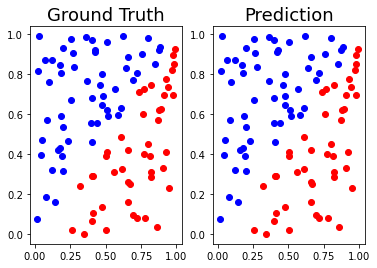

In [35]:
pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

### Run "XOR"

In [25]:
""" Customize your own code if needed """

data, label = GenData.fetch_data('XOR', 100)

net = SimpleNet(2000, 100)

In [26]:
net.learning_rate = 0.01
net.train(data, label)

Epochs 0: 
accuracy: 49.61%
Epochs 100: 
accuracy: 89.48%
Epochs 200: 
accuracy: 92.51%
Epochs 300: 
accuracy: 93.82%
Epochs 400: 
accuracy: 94.70%
Epochs 500: 
accuracy: 95.26%
Epochs 600: 
accuracy: 95.69%
Epochs 700: 
accuracy: 95.94%
Epochs 800: 
accuracy: 96.14%
Epochs 900: 
accuracy: 96.36%
Epochs 1000: 
accuracy: 96.52%
Epochs 1100: 
accuracy: 96.68%
Epochs 1200: 
accuracy: 96.75%
Epochs 1300: 
accuracy: 96.93%
Epochs 1400: 
accuracy: 96.93%
Epochs 1500: 
accuracy: 97.03%
Epochs 1600: 
accuracy: 97.04%
Epochs 1700: 
accuracy: 97.21%
Epochs 1800: 
accuracy: 97.27%
Epochs 1900: 
accuracy: 97.35%
Training finished
accuracy: 97.39%


(100, 2) (100, 1) 100


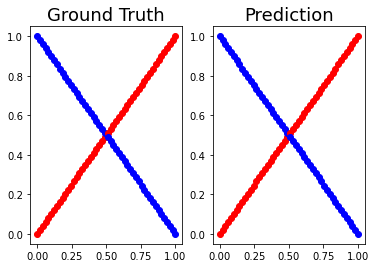

In [29]:
pred_result = np.round(net.forward(data))
SimpleNet.plot_result(data, label, pred_result)

# 討論

在過程中我發現如果三層神經層都用sigmoid當作啟動函數，那麼初始化時如果數值是從0~1之間產生會無法back propagation，<br>
原因是因為當數值過大(或過小)時，他的梯度會變得趨近於0導致無法回饋修正。像是第一層的輸出乘上w2會有大約100個數字相<br>
加，如果所有數字都是正值或負值，則數字可能會增加到50左右，但如果數字有正有負，則運氣不是特別差的話加起來應該還是<br>
接近0。所以我決定前兩層用relu就好，relu的好處就是它基本上不太會去變動原本的梯度，但第三層最終還是要靠sigmoid轉成<br>
0到1的數字，如果前面沒有將數值控制好的話一樣會發生梯度為0的情形，所以前面兩層輸出時要加個normalization，讓數值不<br>
要太大或太小。